# Argentina during Copa América 2024: Web Scraping and Exploratory Data Analysis

## 1. Aims, objectives and background

### 1.1. Introduction
Argentina's national soccer team has emerged as one of the top international teams in history. This project aims to analyze match data from Argentina during the 2024 CONMEBOL Copa América. As a Data Science enthusiast, I am eager to engage with sports data to enhance my skills in data gathering, visualization, and analysis. This project will focus on exploring the statistics of Argentina, the 2024 Copa América champion, through scoping, analyzing, preparing, and plotting data to derive insights from the analysis.

### 1.2. Aims and objectives
* Get acquainted with the data
* Clean the data so it is ready for analysis
* Develop some questions for the analysis
* Analyze variables within the data to gain patterns and insights on these questions

### 1.3. Steps of the project
1. Obtain the matches' data by webscraping Sofascore with a request url
2. Preprocess data and engineer additional features for analysis
3. Exploratory and statistical data analysis, including visualizations
4. Conclusions


### 1.4. Dataset
#### Data selection
As this project is particularly focused on sports statistics and visualizations, I found that Sofascore website would be suitable for this purpose.

#### Loading the Data
First, the necessary libraries are loaded into the notebook. 

In [1]:
import pandas as pd
import numpy as np
import csv
import os
import ast
import re

# Scraping libraries
import requests
from scraping_functions import *
import logging

# Data visualizatoin libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import Pitch

# Statistic functions libraries
from scipy import stats
import math
from scipy.stats import pearsonr

## 2. Data creation with Sofascore request url
Each match's site has its own URL for scraping statistics and shotmap information, so several URLs were needed to create different files for storing the data. Some scraping functions are required first to generate files and dataframes with the desired information.

### 2.1 Functions to gather the data

In [2]:
FULL_MATCH = 'Full Match'
FIRST_HALF = 'First Half'
SECOND_HALF = 'Second Half'
EXTRA_TIME_1 = 'Extra Time 1'
EXTRA_TIME_2 = 'Extra Time 2'


def write_statistics_to_csv(writer, period, groups):
    # writes json data into csv file
    for group in groups:
        group_name = group['groupName']
        for item in group['statisticsItems']:
            writer.writerow([period, group_name, item['name'], item['home'], item['away']])


def extract_stats(url, filename):
    """ 
    Get match statistics: Load stats into csv files
    
    Params:
    url: the specific match URL provided from Sofascore to scrape data.
    filename: the file name we want to give to our csv

    Returns:
    Error handling through try/except blocks
    """ 
    try:
        response = requests.get(url)
        response.raise_for_status()
    except requests.RequestException as error:
        logging.error(f"There has been an error while requesting to {url}: {error}")
        return

    try:
        data = response.json()
        match_stats = data['statistics']
    except (ValueError, KeyError) as error:
        logging.error(f"There has been an error while processing JSON data: {error}")
        return

    if not match_stats:
        logging.warning(f"No statistics found in the gathered data from {url}")
        return

    try:
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Period', 'Group', 'Statistic', 'Home', 'Away'])

            if len(match_stats) >= 3:
                write_statistics_to_csv(writer, FULL_MATCH, match_stats[0]['groups'])
                write_statistics_to_csv(writer, FIRST_HALF, match_stats[1]['groups'])
                write_statistics_to_csv(writer, SECOND_HALF, match_stats[2]['groups'])

            if len(match_stats) == 5:
                write_statistics_to_csv(writer, EXTRA_TIME_1, match_stats[3]['groups'])
                write_statistics_to_csv(writer, EXTRA_TIME_2, match_stats[4]['groups'])

            logging.info(f"Statistics written succesfully in {filename}")

    except IOError as error:
        logging.error(f"Could not write in file {filename}: {error}")


def extract_shotmap(url, filename):
    """ 
    Get shotmap stats: Load stats into csv files
    Params:

    url: the specific match URL provided from Sofascore to scrape data.
    filename: the file name we want to give to our csv

    Returns:
    Error handling messages through try/except blocks
    """ 
    try:
        response = requests.get(url)
        response.raise_for_status()
    except requests.RequestException as error:
        logging.error(f"There has been an error while requesting {url}: {error}")
        return

    try:
        data = response.json()
        shotmap = data['shotmap']
    except (ValueError, KeyError) as error:
        logging.error(f"There has been an error while processing JSON data: {error}")
        return

    if not shotmap:
        logging.warning(f"Shotmap data was not found in {url}")
        return

    try:
        with open(filename, mode='w', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Name', 'Position', 'Outcome', 'Situation', 'Player Coordinates', 'Body Part',
                             'Shot Location', 'Shot Coordinates', 'Expected Goal (xG)',
                             'Expected Goal on Target (xGOT)'])

            for shot in shotmap:
                player_name = shot['player'].get('name', '')
                player_position = shot['player'].get('position', '')                                
                outcome = shot.get('shotType', '')
                situation = shot.get('situation', '')
                player_coordinates = shot.get('playerCoordinates', {})
                body_part = shot.get('bodyPart', '')
                shot_location = shot.get('goalMouthLocation', '')
                shot_coordinates = shot.get('goalMouthCoordinates', {})
                xg = shot.get('xg', 0)
                xgot = shot.get('xgot', 0)

                writer.writerow([player_name, player_position, jersey_number, outcome, situation, player_coordinates,
                                 body_part, shot_location, shot_coordinates, xg, xgot])

            logging.info(f"Shotmap data written succesfully in {filename}")
    except IOError as error:
        logging.error(f"Error while writing in {filename}: {error}")


### 2.2 Loading the data

In [3]:
from scraping_functions import *
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


def main():
    
    data_dicts = [
        {
            # Argentina vs Canada (2 - 0) - Groups phase
            'stats_url': 'https://www.sofascore.com/api/v1/event/11886373/statistics',
            'shotmap_url': 'https://www.sofascore.com/api/v1/event/11886373/shotmap',
            'stats_filename': 'match1_stats.csv',
            'shotmap_filename': 'match1_shotmap.csv'
        },
        {
            # Chile vs Argentina (0 - 1) - Groups phase
            'stats_url': 'https://www.sofascore.com/api/v1/event/11886369/statistics',
            'shotmap_url': 'https://www.sofascore.com/api/v1/event/11886369/shotmap',
            'stats_filename': 'match2_stats.csv',
            'shotmap_filename': 'match2_shotmap.csv'
        },
        {
            # Argentina vs Peru (2 - 0) - Groups phase
            'stats_url': 'https://www.sofascore.com/api/v1/event/11886396/statistics',
            'shotmap_url': 'https://www.sofascore.com/api/v1/event/11886396/shotmap',
            'stats_filename': 'match3_stats.csv',
            'shotmap_filename': 'match3_shotmap.csv'
        },
        {
            # Argentina vs Ecuador (1 - 1)(Penalties: 4 - 2) - Quarter finals
            'stats_url': 'https://www.sofascore.com/api/v1/event/11886594/statistics',
            'shotmap_url': 'https://www.sofascore.com/api/v1/event/11886594/shotmap',
            'stats_filename': 'match4_stats.csv',
            'shotmap_filename': 'match4_shotmap.csv'
        },
        {
            # Argentina vs Canada (2 - 0) - Semi finals
            'stats_url': 'https://www.sofascore.com/api/v1/event/11886259/statistics',
            'shotmap_url': 'https://www.sofascore.com/api/v1/event/11886259/shotmap',
            'stats_filename': 'match5_stats.csv',
            'shotmap_filename': 'match5_shotmap.csv'
        },
        {
            # Argentina vs Colombia (1 - 0) - Final
            'stats_url': 'https://www.sofascore.com/api/v1/event/11886600/statistics',
            'shotmap_url': 'https://www.sofascore.com/api/v1/event/11886600/shotmap',
            'stats_filename': 'match6_stats.csv',
            'shotmap_filename': 'match6_shotmap.csv'
        }
    ]

    try:
        for match_data in data_dicts:
            extract_stats(match_data['stats_url'], match_data['stats_filename'])
            extract_shotmap(match_data['shotmap_url'], match_data['shotmap_filename'])
    except Exception as error:
        logging.error(f"An unexpected error ocurred: {error}")


if __name__ == "__main__":
    main()


2024-10-28 20:21:11,524 - INFO - Statistics written succesfully in match1_stats.csv
2024-10-28 20:21:12,050 - INFO - Shotmap data written succesfully in match1_shotmap.csv
2024-10-28 20:21:12,232 - INFO - Statistics written succesfully in match2_stats.csv
2024-10-28 20:21:12,545 - INFO - Shotmap data written succesfully in match2_shotmap.csv
2024-10-28 20:21:12,719 - INFO - Statistics written succesfully in match3_stats.csv
2024-10-28 20:21:13,049 - INFO - Shotmap data written succesfully in match3_shotmap.csv
2024-10-28 20:21:13,233 - INFO - Statistics written succesfully in match4_stats.csv
2024-10-28 20:21:13,563 - INFO - Shotmap data written succesfully in match4_shotmap.csv
2024-10-28 20:21:13,749 - INFO - Statistics written succesfully in match5_stats.csv
2024-10-28 20:21:14,082 - INFO - Shotmap data written succesfully in match5_shotmap.csv
2024-10-28 20:21:14,279 - INFO - Statistics written succesfully in match6_stats.csv
2024-10-28 20:21:14,610 - INFO - Shotmap data written su

#### Concatenate CSV files into a single DF

In [4]:
directory = r"C:\Users\diego\Sports Analytics\Beginner_Projects\Argentina_CopaAmerica2024"

stats_dfs = []
shotmap_dfs = []

filenames = os.listdir(directory)
for filename in filenames:
    filepath = os.path.join(directory, filename)  # Full path to the file
    
    
    match_id = filename.split('_')[0]  # Extracts 'match1', 'match2', etc.
    
    if 'stats' in filename.lower() and filename.endswith('.csv'):
        df = pd.read_csv(filepath)  
        df['match_id'] = match_id[5]
        stats_dfs.append(df)  
    
    elif 'shotmap' in filename.lower() and filename.endswith('.csv'):
        df = pd.read_csv(filepath)
        df['match_id'] = match_id[5] 
        shotmap_dfs.append(df)  

stats_concatenated_df = pd.concat(stats_dfs, ignore_index=True)
shotmaps_concatenated_df = pd.concat(shotmap_dfs, ignore_index=True)

### 2.3 Data Inspection & Cleansing

In [5]:
stats_concatenated_df

,Period,Group,Statistic,Home,Away,match_id
0,Full Match,Match overview,Ball possession,64%,36%,1
1,Full Match,Match overview,Expected goals,3.02,1.16,1
2,Full Match,Match overview,Big chances,9,2,1
3,Full Match,Match overview,Total shots,19,10,1
4,Full Match,Match overview,Goalkeeper saves,2,6,1
...,...,...,...,...,...,...
804,Extra Time 2,Defending,Interceptions,2,1,6
805,Extra Time 2,Defending,Recoveries,10,8,6
806,Extra Time 2,Defending,Clearances,9,1,6
807,Extra Time 2,Goalkeeping,Total saves,0,0,6


In [6]:
# Argentina was named a visitor in match 2, so we need to switch the 'Home' and 'Away' data in that field
stats_concatenated_df.loc[stats_concatenated_df['match_id'] == '2', ['Home', 'Away']] = stats_concatenated_df.loc[stats_concatenated_df['match_id'] == '2', ['Away', 'Home']].values


In [7]:
stats_concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Period     809 non-null    object
 1   Group      809 non-null    object
 2   Statistic  809 non-null    object
 3   Home       809 non-null    object
 4   Away       809 non-null    object
 5   match_id   809 non-null    object
dtypes: object(6)
memory usage: 38.1+ KB


In [8]:
stats_concatenated_df.isnull().any()

Period       False
Group        False
Statistic    False
Home         False
Away         False
match_id     False
dtype: bool

In [9]:
stats_concatenated_df.duplicated().sum()

0

#### There is no duplicated nor missing data

In [10]:
stats_concatenated_df.describe()

,Period,Group,Statistic,Home,Away,match_id
count,809,809,809,809,809,809
unique,5,7,45,226,223,6
top,Full Match,Match overview,Total shots,0,0,6
freq,263,206,40,99,122,201


In [11]:
stats_concatenated_df.shape

(809, 6)

In [12]:
shotmaps_concatenated_df.head()

,Name,Position,Outcome,Situation,Player Coordinates,Body Part,Shot Location,Shot Coordinates,Expected Goal (xG),Expected Goal on Target (xGOT),match_id
0,Lionel Messi,F,save,free-kick,"{'x': 23.5, 'y': 57.3, 'z': 0}",left-foot,high-right,"{'x': 0, 'y': 47.2, 'z': 24.7}",0.071207,0.2324,1
1,Jacob Shaffelburg,M,save,set-piece,"{'x': 23.3, 'y': 68.7, 'z': 0}",left-foot,low-centre,"{'x': 0, 'y': 48.9, 'z': 2.5}",0.023184,0.0416,1
2,Lautaro Martínez,F,goal,assisted,"{'x': 11.1, 'y': 57.1, 'z': 0}",right-foot,low-centre,"{'x': 0, 'y': 49, 'z': 3.8}",0.594084,0.6147,1
3,Nicolás Otamendi,D,miss,set-piece,"{'x': 3.3, 'y': 49.8, 'z': 0}",left-foot,high,"{'x': 0, 'y': 50.4, 'z': 62.5}",0.345816,0.0000,1
4,Lautaro Martínez,F,save,assisted,"{'x': 15.7, 'y': 43.2, 'z': 0}",right-foot,low-centre,"{'x': 0, 'y': 49.7, 'z': 1.9}",0.401235,0.1469,1


In [13]:
shotmaps_concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Name                            148 non-null    object 
 1   Position                        148 non-null    object 
 2   Outcome                         148 non-null    object 
 3   Situation                       148 non-null    object 
 4   Player Coordinates              148 non-null    object 
 5   Body Part                       148 non-null    object 
 6   Shot Location                   148 non-null    object 
 7   Shot Coordinates                148 non-null    object 
 8   Expected Goal (xG)              148 non-null    float64
 9   Expected Goal on Target (xGOT)  148 non-null    float64
 10  match_id                        148 non-null    object 
dtypes: float64(2), object(9)
memory usage: 12.8+ KB


In [14]:
shotmaps_concatenated_df.isnull().any()

Name                              False
Position                          False
Outcome                           False
Situation                         False
Player Coordinates                False
Body Part                         False
Shot Location                     False
Shot Coordinates                  False
Expected Goal (xG)                False
Expected Goal on Target (xGOT)    False
match_id                          False
dtype: bool

In [15]:
shotmaps_concatenated_df.duplicated().sum()

0

In [16]:
shotmaps_concatenated_df.describe()

,Expected Goal (xG),Expected Goal on Target (xGOT)
count,148.000000,148.000000
mean,0.165239,0.143372
std,0.223223,0.285739
min,0.007839,0.000000
25%,0.029236,0.000000
50%,0.059633,0.000000
75%,0.174314,0.104500
max,0.788400,0.996100


In [17]:
shotmaps_concatenated_df.shape

(148, 11)

In [18]:
print(f"Number of match stats: {stats_concatenated_df.Statistic.nunique()}\n")
print(f"Match Stats:\n")
for stat in stats_concatenated_df.Statistic.unique():
    print(stat)

Number of match stats: 45

Match Stats:

Ball possession
Expected goals
Big chances
Total shots
Goalkeeper saves
Corner kicks
Fouls
Passes
Tackles
Free kicks
Yellow cards
Shots on target
Hit woodwork
Shots off target
Blocked shots
Shots inside box
Shots outside box
Big chances scored
Big chances missed
Through balls
Touches in penalty area
Fouled in final third
Offsides
Accurate passes
Throw-ins
Final third entries
Final third phase
Long balls
Crosses
Duels
Dispossessed
Ground duels
Aerial duels
Dribbles
Tackles won
Total tackles
Interceptions
Recoveries
Clearances
Total saves
Goals prevented
High claims
Goal kicks
Errors lead to a shot
Big saves


In [19]:
print(f"Columns in shotmap dataframe: {len(shotmaps_concatenated_df.columns)}\n")
print(f"Shotmap columns:")
for column in shotmaps_concatenated_df.columns:
    print(column)

Columns in shotmap dataframe: 11

Shotmap columns:
Name
Position
Outcome
Situation
Player Coordinates
Body Part
Shot Location
Shot Coordinates
Expected Goal (xG)
Expected Goal on Target (xGOT)
match_id


*Converting object columns into floats*

In [20]:
def extract_percentage(value):
    
    match1 = re.search(r'\((\d+)%\)', str(value))  
    match2 = re.search(r'(\d+)%', str(value))
    if match1:
        return float(match1.group(1))  

    if match2:
        return float(match2.group(1))  
        
    return float(value)


stats_concatenated_df['Home'] = stats_concatenated_df['Home'].apply(extract_percentage)
stats_concatenated_df['Away'] = stats_concatenated_df['Away'].apply(extract_percentage)
stats_concatenated_df[0:50]
stats_concatenated_df.dtypes

Period        object
Group         object
Statistic     object
Home         float64
Away         float64
match_id      object
dtype: object

In [21]:
shotmaps_concatenated_df.dtypes

Name                               object
Position                           object
Outcome                            object
Situation                          object
Player Coordinates                 object
Body Part                          object
Shot Location                      object
Shot Coordinates                   object
Expected Goal (xG)                float64
Expected Goal on Target (xGOT)    float64
match_id                           object
dtype: object

In [22]:
# looks like player coordinates are stored in a dictionary
shotmaps_concatenated_df['Player Coordinates']

0      {'x': 23.5, 'y': 57.3, 'z': 0}
1      {'x': 23.3, 'y': 68.7, 'z': 0}
2      {'x': 11.1, 'y': 57.1, 'z': 0}
3       {'x': 3.3, 'y': 49.8, 'z': 0}
4      {'x': 15.7, 'y': 43.2, 'z': 0}
                    ...              
143    {'x': 13.3, 'y': 45.2, 'z': 0}
144       {'x': 7, 'y': 48.5, 'z': 0}
145      {'x': 13, 'y': 59.3, 'z': 0}
146    {'x': 23.1, 'y': 31.5, 'z': 0}
147      {'x': 13.6, 'y': 53, 'z': 0}
Name: Player Coordinates, Length: 148, dtype: object

In [23]:
# it is actually a string
shotmaps_concatenated_df['Player Coordinates'][0]

"{'x': 23.5, 'y': 57.3, 'z': 0}"

In [24]:
shotmaps_concatenated_df['Player Coordinates'][0][4]

':'

In [25]:
# Apply literal_eval to the entire column to convert strings to dictionaries
shotmaps_concatenated_df['Player Coordinates'] = shotmaps_concatenated_df['Player Coordinates'].apply(ast.literal_eval)

In [26]:
shotmaps_concatenated_df['Player Coordinates'][0]

{'x': 23.5, 'y': 57.3, 'z': 0}

## 3. Exploratory Data Analysis | Summary Statistics

### 3.1 Shotmap locations

In [27]:
shotmaps_concatenated_df.head()

,Name,Position,Outcome,Situation,Player Coordinates,Body Part,Shot Location,Shot Coordinates,Expected Goal (xG),Expected Goal on Target (xGOT),match_id
0,Lionel Messi,F,save,free-kick,"{'x': 23.5, 'y': 57.3, 'z': 0}",left-foot,high-right,"{'x': 0, 'y': 47.2, 'z': 24.7}",0.071207,0.2324,1
1,Jacob Shaffelburg,M,save,set-piece,"{'x': 23.3, 'y': 68.7, 'z': 0}",left-foot,low-centre,"{'x': 0, 'y': 48.9, 'z': 2.5}",0.023184,0.0416,1
2,Lautaro Martínez,F,goal,assisted,"{'x': 11.1, 'y': 57.1, 'z': 0}",right-foot,low-centre,"{'x': 0, 'y': 49, 'z': 3.8}",0.594084,0.6147,1
3,Nicolás Otamendi,D,miss,set-piece,"{'x': 3.3, 'y': 49.8, 'z': 0}",left-foot,high,"{'x': 0, 'y': 50.4, 'z': 62.5}",0.345816,0.0000,1
4,Lautaro Martínez,F,save,assisted,"{'x': 15.7, 'y': 43.2, 'z': 0}",right-foot,low-centre,"{'x': 0, 'y': 49.7, 'z': 1.9}",0.401235,0.1469,1


#### filtering Argentina players

In [28]:
argentina_players = ("Emiliano Martínez", "Franco Armani", "Gerónimo Rulli",
                    "Gonzalo Montiel", "Nahuel Molina", "Leonardo Balerdi", "Cristian Romero",
                    "Germán Pezzella", "Nicolás Otamendi", "Lisandro Martínez", "Marcos Acuña",
                    "Nicolás Tagliafico", "Guido Rodríguez", "Leandro Paredes", "Alexis Mac Allister",
                    "Rodrigo De Paul", "Exequiel Palacios", "Enzo Fernández", "Giovani Lo Celso",
                    "Lionel Messi", "Ángel Di María", "Alejandro Garnacho", "Valentín Carboni",
                    "Nicolás González", "Lautaro Martínez", "Julián Álvarez")

In [29]:
shotmap_argentina = shotmaps_concatenated_df[shotmaps_concatenated_df.Name.isin(argentina_players)]
shotmap_argentina.head(10)

,Name,Position,Outcome,Situation,Player Coordinates,Body Part,Shot Location,Shot Coordinates,Expected Goal (xG),Expected Goal on Target (xGOT),match_id
0,Lionel Messi,F,save,free-kick,"{'x': 23.5, 'y': 57.3, 'z': 0}",left-foot,high-right,"{'x': 0, 'y': 47.2, 'z': 24.7}",0.071207,0.2324,1
2,Lautaro Martínez,F,goal,assisted,"{'x': 11.1, 'y': 57.1, 'z': 0}",right-foot,low-centre,"{'x': 0, 'y': 49, 'z': 3.8}",0.594084,0.6147,1
3,Nicolás Otamendi,D,miss,set-piece,"{'x': 3.3, 'y': 49.8, 'z': 0}",left-foot,high,"{'x': 0, 'y': 50.4, 'z': 62.5}",0.345816,0.0000,1
4,Lautaro Martínez,F,save,assisted,"{'x': 15.7, 'y': 43.2, 'z': 0}",right-foot,low-centre,"{'x': 0, 'y': 49.7, 'z': 1.9}",0.401235,0.1469,1
5,Nicolás Otamendi,D,miss,set-piece,"{'x': 9.4, 'y': 46.6, 'z': 0}",head,right,"{'x': 0, 'y': 39.7, 'z': 8.3}",0.220899,0.0000,1
6,Lionel Messi,F,miss,fast-break,"{'x': 13.8, 'y': 56.4, 'z': 0}",left-foot,close-left,"{'x': 0, 'y': 57.8, 'z': 2.8}",0.169258,0.0000,1
7,Giovani Lo Celso,M,block,assisted,"{'x': 13.3, 'y': 60.8, 'z': 0}",left-foot,low-centre,"{'x': 0, 'y': 51, 'z': 19}",0.052212,0.0000,1
10,Lionel Messi,F,save,fast-break,"{'x': 12.5, 'y': 45, 'z': 0}",left-foot,low-centre,"{'x': 0, 'y': 50.1, 'z': 19}",0.211307,0.0000,1
11,Lionel Messi,F,save,fast-break,"{'x': 13.5, 'y': 34.9, 'z': 0}",left-foot,low-right,"{'x': 0, 'y': 47, 'z': 1.9}",0.158272,0.3815,1
12,Ángel Di María,M,miss,assisted,"{'x': 21.9, 'y': 69.1, 'z': 0}",left-foot,high,"{'x': 0, 'y': 48.9, 'z': 73.6}",0.038446,0.0000,1


In [30]:
# Extracting x, y values into a list
x_coords = shotmap_argentina['Player Coordinates'].apply(lambda coord: coord['x']).tolist()
y_coords = shotmap_argentina['Player Coordinates'].apply(lambda coord: coord['y']).tolist()
coordinates_tuples = list(zip(x_coords, y_coords))
print(coordinates_tuples)

[(23.5, 57.3), (11.1, 57.1), (3.3, 49.8), (15.7, 43.2), (9.4, 46.6), (13.8, 56.4), (13.3, 60.8), (12.5, 45.0), (13.5, 34.9), (21.9, 69.1), (13.9, 46.8), (4.1, 62.3), (8.5, 25.7), (22.5, 67.1), (10.8, 54.0), (8.3, 67.3), (14.3, 55.3), (22.6, 30.5), (10.2, 29.4), (7.6, 45.2), (7.7, 42.5), (2.6, 51.5), (6.0, 55.6), (12.6, 61.8), (13.3, 33.1), (4.6, 46.6), (15.1, 37.4), (9.4, 65.1), (20.3, 35.8), (26.8, 38.3), (4.8, 40.3), (3.5, 63.0), (30.1, 54.8), (19.2, 46.4), (21.9, 31.0), (1.7, 36.6), (8.9, 44.2), (11.8, 39.9), (10.2, 36.4), (14.5, 30.3), (12.0, 52.4), (11.5, 50.0), (12.0, 57.3), (14.5, 32.7), (11.4, 52.1), (21.5, 70.9), (11.3, 45.5), (25.7, 33.5), (14.2, 37.0), (11.5, 50.0), (11.5, 50.0), (11.5, 50.0), (11.5, 50.0), (11.5, 50.0), (14.6, 47.1), (16.0, 46.9), (10.8, 35.8), (13.2, 38.3), (11.1, 35.6), (3.0, 42.5), (13.5, 60.9), (11.9, 45.4), (14.0, 61.7), (4.6, 50.7), (15.5, 46.6), (18.4, 46.8), (12.8, 42.5), (9.6, 62.4), (11.3, 30.5), (18.4, 71.4), (11.9, 51.0), (58.8, 63.0), (20.7, 62

#### Central Tendency measures

In [31]:
print(f"Average x coordinate: {np.mean(x_coords):.1f}")
print(f"Average y coordinate: {np.mean(y_coords):.1f}")
print(f"Median x coordinate: {np.median(x_coords):.1f}")
print(f"Median y coordinate: {np.median(y_coords):.1f}")
print(f"Midrange x coordiante: {(np.min(x_coords) + np.max(x_coords)) / 2:.1f}")
print(f"Midrange y coordiante: {(np.min(y_coords) + np.max(y_coords)) / 2:.1f}")

Average x coordinate: 13.8
Average y coordinate: 47.9
Median x coordinate: 11.9
Median y coordinate: 46.8
Midrange x coordiante: 36.8
Midrange y coordiante: 48.6


#### Dispersion measures

In [32]:
print(f"Standard deviation x coordinate: {np.std(x_coords):.1f}")
print(f"Standard deviation y coordinate: {np.std(y_coords):.1f}")
print(f"variance x coordinate: {np.var(x_coords):.1f}")
print(f"variance y coordinate: {np.var(y_coords):.1f}")

Standard deviation x coordinate: 9.9
Standard deviation y coordinate: 11.1
variance x coordinate: 97.4
variance y coordinate: 123.3


#### Frecuency Table and Histograms for shot locations

In [33]:
# calculating bins: sturges rule
import math
c = round(1 + 3.3 * math.log10(shotmap_argentina.shape[0]))
c

7

In [34]:
amplitude_Xcoords = round((max(x_coords) - min(x_coords)) / c, 1) + 0.02
amplitude_Ycoords = round((max(y_coords) - min(y_coords)) / c, 1) + 0.03

In [35]:
# Calculate intervals with rounding
x_intervals = [(round(min(x_coords) + i * amplitude_Xcoords, 3), 
                 round(min(x_coords) + (i + 1) * amplitude_Xcoords, 3)) 
                for i in range(c)]

y_intervals = [(round(min(y_coords) + i * amplitude_Ycoords, 3), 
                 round(min(y_coords) + (i + 1) * amplitude_Ycoords, 3)) 
                for i in range(c)]


# Create frequency counts for x and y coordinates
frequency_x = [sum(1 for x in x_coords if interval[0] <= x < interval[1]) for interval in x_intervals]
frequency_y = [sum(1 for y in y_coords if interval[0] <= y < interval[1]) for interval in y_intervals]

# Calculate total frequencies
total_x = sum(frequency_x)
total_y = sum(frequency_y)

# Calculate proportions and percentages
proportion_x = [f"{fx}/{total_x}" for fx in frequency_x]
proportion_y = [f"{fy}/{total_y}" for fy in frequency_y]
percentage_x = [fx / total_x if total_x > 0 else 0 for fx in frequency_x]
percentage_y = [fy / total_y if total_y > 0 else 0 for fy in frequency_y]

# Create DataFrame
data = {
    'X_Interval': x_intervals,
    'Y_Interval': y_intervals,
    'X_Frecuency': frequency_x,
    'Y_Frecuency': frequency_y,
    'X_Proportion': proportion_x,
    'Y_Proportion': proportion_y,
    'X_Percentage': percentage_x,
    'Y_Percentage': percentage_y
}

frecuency_table = pd.DataFrame(data)

# Print the DataFrame
frecuency_table


,X_Interval,Y_Interval,X_Frecuency,Y_Frecuency,X_Proportion,Y_Proportion,X_Percentage,Y_Percentage
0,"(1.7, 11.72)","(25.7, 32.23)",40,7,40/84,7/84,0.476190,0.083333
1,"(11.72, 21.74)","(32.23, 38.76)",34,15,34/84,15/84,0.404762,0.178571
2,"(21.74, 31.76)","(38.76, 45.29)",8,12,8/84,12/84,0.095238,0.142857
3,"(31.76, 41.78)","(45.29, 51.82)",0,22,0/84,22/84,0.000000,0.261905
4,"(41.78, 51.8)","(51.82, 58.35)",0,12,0/84,12/84,0.000000,0.142857
5,"(51.8, 61.82)","(58.35, 64.88)",1,10,1/84,10/84,0.011905,0.119048
6,"(61.82, 71.84)","(64.88, 71.41)",1,6,1/84,6/84,0.011905,0.071429


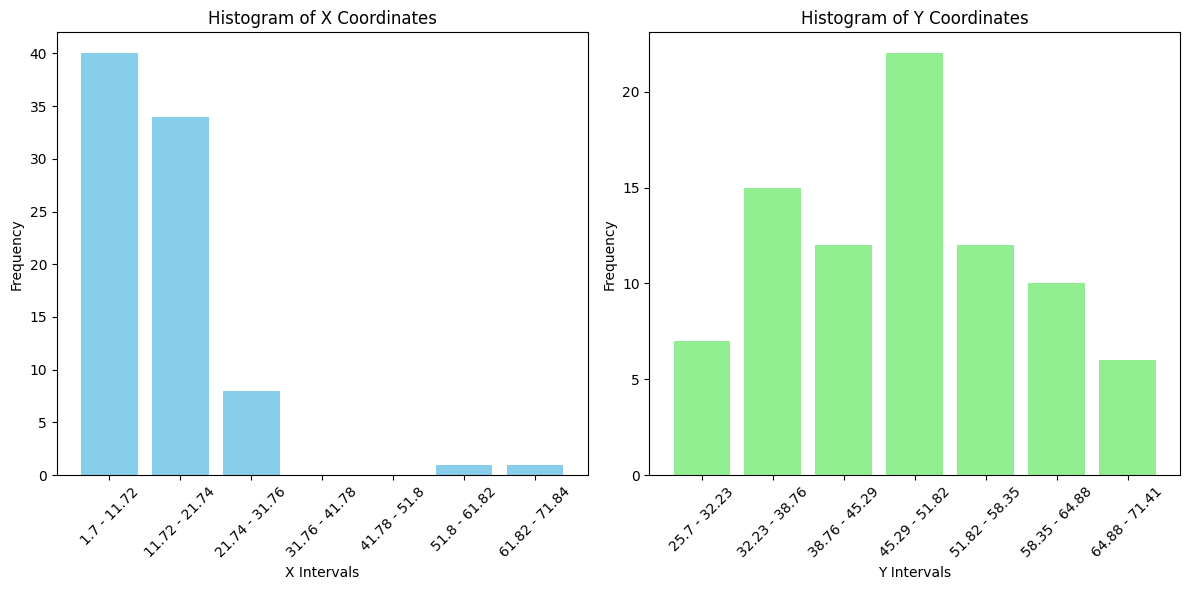

In [36]:
# Plotting Histogram for X Coordinates
plt.figure(figsize=(12, 6))

# Bar plot for X Frequencies
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.bar([f"{interval[0]} - {interval[1]}" for interval in frecuency_table['X_Interval']], frecuency_table['X_Frecuency'], color='skyblue')
plt.title('Histogram of X Coordinates')
plt.xlabel('X Intervals')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x labels for better visibility

# Bar plot for Y Frequencies
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.bar([f"{interval[0]} - {interval[1]}" for interval in frecuency_table['Y_Interval']], frecuency_table['Y_Frecuency'], color='lightgreen')
plt.title('Histogram of Y Coordinates')
plt.xlabel('Y Intervals')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x labels for better visibility

plt.tight_layout()  # Adjusts subplots to fit into the figure area.
plt.show()


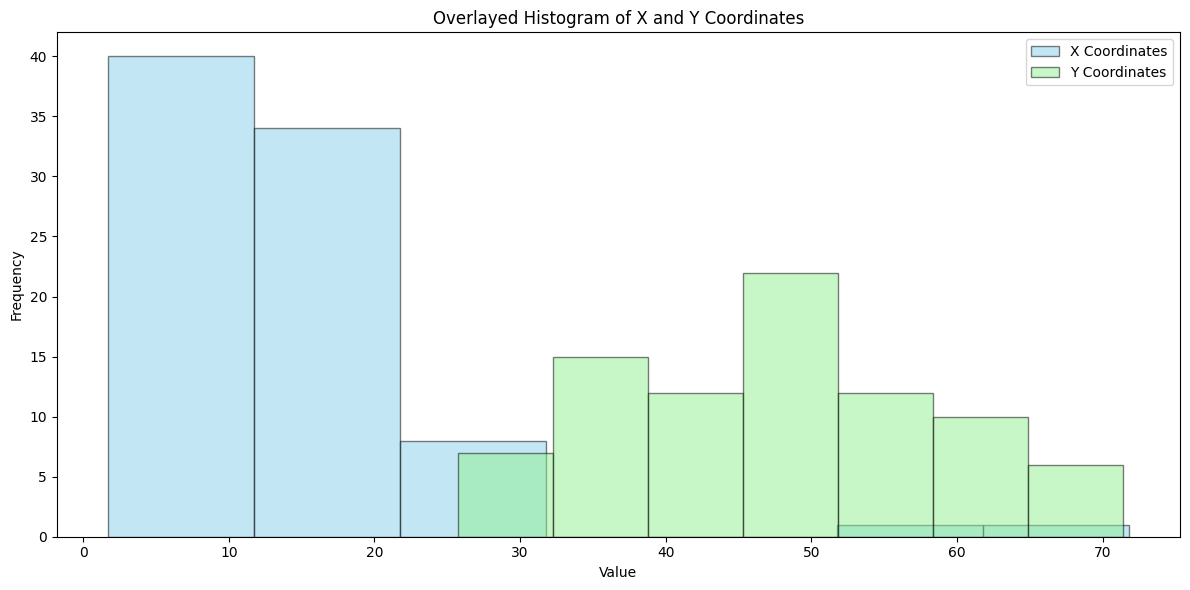

In [37]:
# Create the histogram using plt.hist()
plt.figure(figsize=(12, 6))
plt.hist(x_coords, bins=c, alpha=0.5, label='X Coordinates', color='skyblue', edgecolor='black')
plt.hist(y_coords, bins=c, alpha=0.5, label='Y Coordinates', color='lightgreen', edgecolor='black')
plt.title('Overlayed Histogram of X and Y Coordinates')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


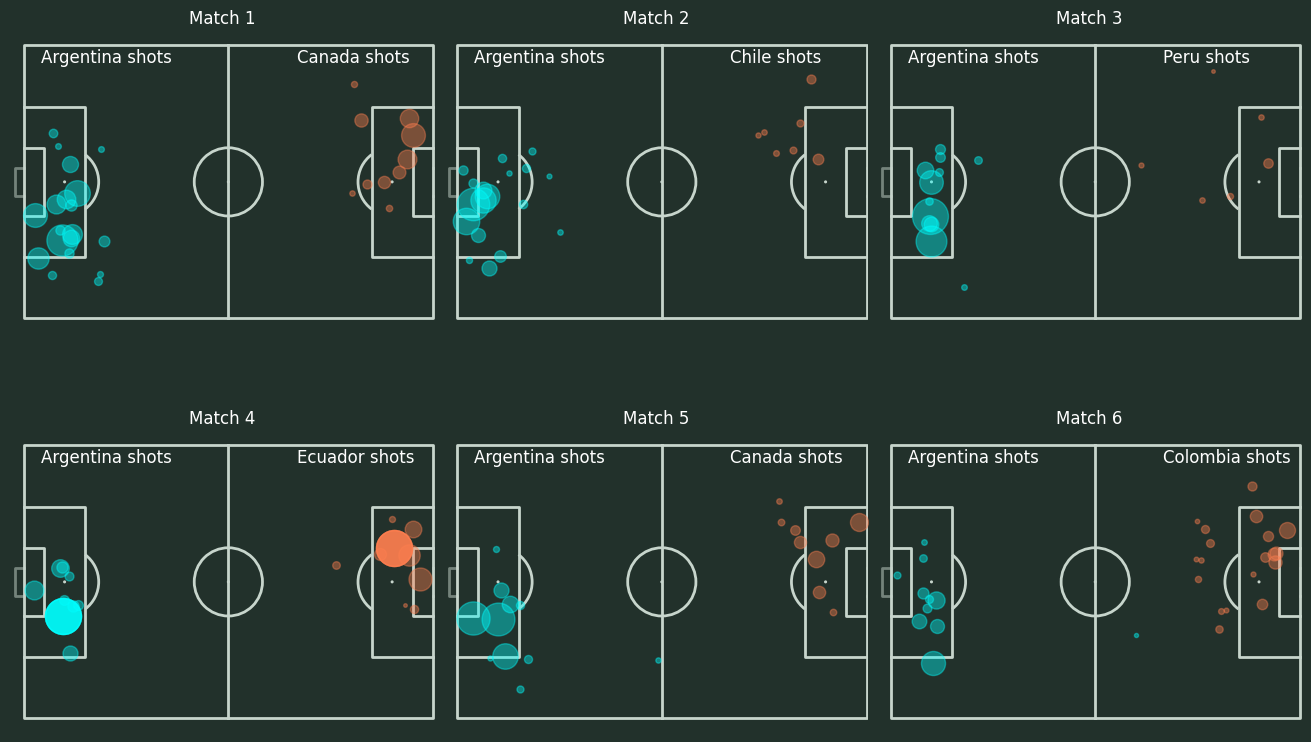

In [38]:
rivals = ('Canada', 'Chile', 'Peru', 'Ecuador', 'Canada', 'Colombia')

def generateCombinedShotmaps(ax, shotmap_df, f_argentinaplayers, rival, match_number):
    # create pitch
    pitch = Pitch(
        pad_right=0.5,
        pitch_type='statsbomb', 
        line_color='#c7d5cc',
        pitch_color='#22312b',
        goal_alpha=0.5,
        goal_type='box',
    )
    
    pitch.draw(ax=ax)
    
    # scatter the shots
    for _, row in shotmap_df.iterrows():
        coordinate_to_dict = ast.literal_eval(row['Player Coordinates'])
        x = coordinate_to_dict['x']
        y = coordinate_to_dict['y']
        if row.Name in f_argentinaplayers:
            pitch.scatter(x, y, s=row['Expected Goal (xG)']*850, c='cyan', marker='o', alpha=0.4, ax=ax)
        else:
            pitch.scatter(120-x, 80-y, s=row['Expected Goal (xG)']*850, c='coral', marker='o', alpha=0.4, ax=ax)

    ax.text(5, 5, 'Argentina shots', color='white', size=12)
    ax.text(80, 5, rival+' shots', color='white', size=12)
    ax.set_title(f'Match {match_number}' , color='white')

# Define the number of rows and columns
n_rows = 2
n_cols = 3

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, 8), constrained_layout=True)
fig.patch.set_facecolor('#22312b')

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Generate each shot map
for i in range(len(axes)):
    generateCombinedShotmaps(axes[i], shotmap_dfs[i], argentina_players, rivals[i], i+1)

# Hide any unused subplots 
for j in range(len(shotmap_dfs), len(axes)):
    axes[j].axis('off')

plt.show()


## 4. Hypothesis Testing

### Improvement Over Time Hypothesis

In [39]:
stats_concatenated_df['match_id'] = stats_concatenated_df['match_id'].astype(int)

In [40]:
# Split the DataFrame based on the integer 'match_id' column
groups_phase_df = stats_concatenated_df[stats_concatenated_df['match_id'].between(1, 3)]
ko_stage_df = stats_concatenated_df[stats_concatenated_df['match_id'].between(4, 6)]

In [41]:
# Define a function to calculate average for a given statistic and phase
def calculate_average_stat(df, statistic, phase):
    phase_df = df[(df['Statistic'] == statistic) & (df['Period'] == 'Full Match')]
    return phase_df['Home'].mean()

avg_stats = {
    "Groups Phase": {},
    "Knockout Stage": {}
}

metrics = ['Big chances scored', 'Shots on target', 'Ball possession', 
           'Expected goals', 'Big chances missed', 'Accurate passes']

for metric in metrics:
    avg_stats["Groups Phase"][metric] = calculate_average_stat(groups_phase_df, metric, 'Groups Phase')
    avg_stats["Knockout Stage"][metric] = calculate_average_stat(ko_stage_df, metric, 'Knockout Stage')

for phase, stats in avg_stats.items():
    print(f"\n{phase} Averages:")
    for stat, avg in stats.items():
        print(f"{stat}: {avg:.1f}")



Groups Phase Averages:
Big chances scored: 1.7
Shots on target: 8.0
Ball possession: 66.3
Expected goals: 2.7
Big chances missed: 4.3
Accurate passes: 530.0

Knockout Stage Averages:
Big chances scored: 1.3
Shots on target: 3.7
Ball possession: 49.0
Expected goals: 1.4
Big chances missed: 0.3
Accurate passes: 369.0


### Hypothesis Test

#### Implementation

   - **Null Hypothesis (H_0)**: The mean of each performance metric is the same in the group stage and knockout stage.
   - **Alternative Hypothesis (H_1)**: The mean of each performance metric differs between the group stage and knockout stage.

   - I defined a significance threshold of 0.05.

In [42]:
from scipy.stats import ttest_ind

def hypothesis_test(groups_df, knockout_df, metric):
    group_metric_values = groups_df[(groups_df['Statistic'] == metric) & (groups_df['Period'] == 'Full Match')]['Home']
    ko_metric_values = knockout_df[(knockout_df['Statistic'] == metric) & (knockout_df['Period'] == 'Full Match')]['Home']
    
    t_stat, p_value = ttest_ind(group_metric_values, ko_metric_values, equal_var=False)
    
    print(f"{metric}: t-statistic = {t_stat:.2f}, p-value = {p_value:.3f}")
    if p_value < 0.05:
        print(f"Result: Significant difference between group stage and knockout stage for '{metric}' (p < 0.05)\n")
    else:
        print(f"Result: No significant difference between group stage and knockout stage for '{metric}' (p >= 0.05)\n")

# Metrics to test
metrics = ['Big chances scored', 'Shots on target', 'Ball possession', 
           'Expected goals', 'Big chances missed', 'Accurate passes']

# Run hypothesis test for each metric
for metric in metrics:
    hypothesis_test(groups_phase_df, ko_stage_df, metric)



Big chances scored: t-statistic = 0.71, p-value = 0.519
Result: No significant difference between group stage and knockout stage for 'Big chances scored' (p >= 0.05)

Shots on target: t-statistic = 2.77, p-value = 0.052
Result: No significant difference between group stage and knockout stage for 'Shots on target' (p >= 0.05)

Ball possession: t-statistic = 3.93, p-value = 0.030
Result: Significant difference between group stage and knockout stage for 'Ball possession' (p < 0.05)

Expected goals: t-statistic = 2.79, p-value = 0.069
Result: No significant difference between group stage and knockout stage for 'Expected goals' (p >= 0.05)

Big chances missed: t-statistic = 2.68, p-value = 0.104
Result: No significant difference between group stage and knockout stage for 'Big chances missed' (p >= 0.05)

Accurate passes: t-statistic = 4.18, p-value = 0.015
Result: Significant difference between group stage and knockout stage for 'Accurate passes' (p < 0.05)



### Conclusion

The shotmap analysis indicates that players predominantly take shots from central positions close to the goal and within the penalty box. Outliers are not significantly distant from the primary cluster of shot locations. The scatterplot, with circle sizes representing expected goal (xG) values, shows that most of the larger circles are concentrated in these central areas, highlighting higher xG opportunities in these positions.

Regarding the team's performance metrics, the hypothesis testing indicates a substantial decrease in ball possession from the group phase to the knockout stage. This decline is mirrored in the accuracy of passes, which also dropped in the knockout stage, suggesting that reduced pass accuracy contributed to the drop in ball possession.

#### Next Steps
This dataset holds additional untapped potential for further analysis. Future directions could include:
* Evaluating the effectiveness of expected goals
* Identifying the optimal shot locations for scoring
* Analyzing defensive metrics such as tackles, interceptions, and blocks to understand Argentina's defensive strengths and weaknesses in each tournament stage